In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [23]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datatools as dtools
from time import time



In [3]:
#
import tensorflow as tf

# tf.enable_eager_execution()

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors


# Distributions

In [57]:
l_l1s1 = tfd.Logistic(1., 1.)
val = l_l1s1.sample(int(1e5)).numpy()
pois1 = tfd.Poisson(1.)
valp1 = pois1.sample(int(1e5)).numpy()
norm_l1s1 = tfd.Normal(1., 1.)
valn11 = norm_l1s1.sample(int(1e5)).numpy()
l_l10s1 = tfd.Logistic(10., 1.)
val10 = l_l10s1.sample(int(1e5)).numpy()

In [58]:
def logistic(x, loc, scale):
    return 1/(1 + np.exp(-(x-loc)/scale))

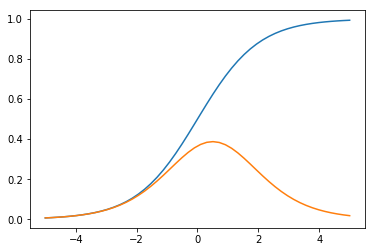

In [59]:
xx = np.linspace(-5, 5)
plt.plot(xx, logistic(xx, 0, 1))
plt.plot(xx, logistic(xx, 0, 1)*logistic(1-xx, 0, 1))

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


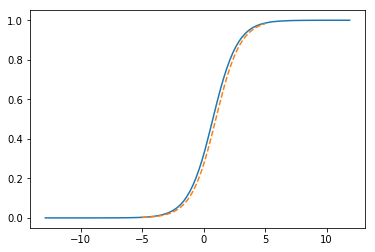

In [60]:
cdf, x = np.histogram(val, bins=100, normed=True)
x = x[:-1]
cdf = np.cumsum(cdf)
cdf /= cdf[-1]
plt.plot(x, cdf)
plt.plot(xx, logistic(xx, 1, 1), '--')

/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


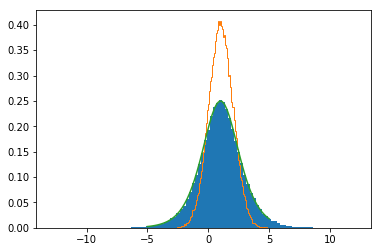

In [61]:
plt.hist(val, bins=100, normed=True)
# plt.hist(valp1, bins=100, normed=True)
plt.hist(valn11, bins=100, normed=True, histtype='step')
plt.plot(xx, logistic(xx, 1, 1)*(1-logistic(xx, 1, 1)))
# plt.hist(val10, bins=100)
# plt.show()

# Data

In [26]:
#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]

In [27]:
# suff = 'pad2'
cube_sizes = np.array([8, 16, 32, 64])
num_cubes= 500#(500*8/cube_sizes).astype('int')
pad = 2
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
nchannels = len(ftname)
rprob = 0.5

In [6]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
hmeshes = {}
#cube_features, cube_target = [], []
# cube_features, cube_target = {}, {}
cube_fthalos, cube_tghalos = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmeshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['pnn']
    for i, size in enumerate(cube_sizes):
        numcubes = int(num_cubes/size*4)
        features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i],
                                           size, cube_sizesft[i], seed=seed, rprob=0)
        cube_fthalos[i] = cube_fthalos[i] + features
        cube_tghalos[i] = cube_tghalos[i] + target

# #
for i in range(cube_sizes.size):
    cube_tghalos[i] = np.stack(cube_tghalos[i],axis=0)
    cube_fthalos[i] = np.stack(cube_fthalos[i],axis=0)
    print(cube_fthalos[i].shape, cube_tghalos[i].shape)


All the mesh have been generated for seed = 100
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 200
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 300
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 400
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of targets =  1
Supplemented by rotation :  0
Length of tar

In [7]:
#Galaxy 


cube_sizes = np.array([8, 16, 32, 64])
num_cubes= 500#(500*8/cube_sizes).astype('int')
pad = 0
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
nchannels = len(ftname)
rprob = 0.0
    
    
#############################
##Read data and generate meshes
gmeshes = {}
cube_ftgal, cube_tggal = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)

    gmeshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)

    for i, size in enumerate(cube_sizes):
        numcubes = int(num_cubes/size*4)
        features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i], 
                                            size, cube_sizesft[i], seed=seed, rprob=0)
        cube_ftgal[i] = cube_ftgal[i] + features
        cube_tggal[i] = cube_tggal[i] + target

# #
for i in range(cube_sizes.size):
    cube_tggal[i] = np.stack(cube_tggal[i],axis=0)
    cube_ftgal[i] = np.stack(cube_ftgal[i],axis=0)
    print(cube_ftgal[i].shape, cube_tggal[i].shape)

    


All the mesh have been generated for seed = 100
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
All the mesh have been generated for seed = 200
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
All the mesh have been generated for seed = 300
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
All the mesh have been generated for seed = 400
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of targets =  2
Supplemented by rotation :  0
Length of tar

Text(0.5, 1.0, 'Target')

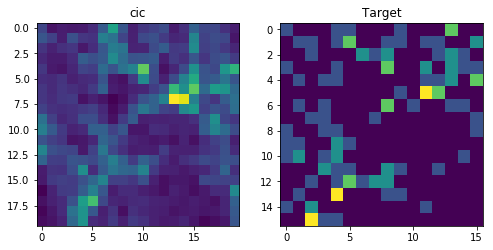

In [8]:
fig, ax = plt.subplots(1, nchannels+1, figsize = (nchannels*4+4, 5))
n = 1
for i in range(nchannels):
    ax[i].imshow(cube_fthalos[n][0, :,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
ax[-1].imshow(cube_tghalos[n][0, :,:,:,0].sum(axis=0))
ax[-1].set_title('Target')

Text(0.5, 1.0, 'Target')

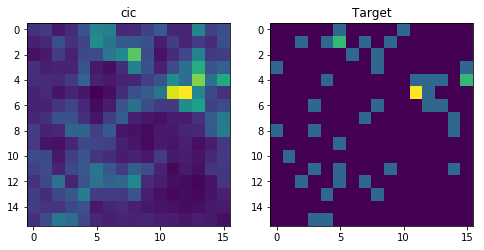

In [9]:
fig, ax = plt.subplots(1, nchannels+1, figsize = (nchannels*4+4, 5))
n = 1
for i in range(nchannels):
    ax[i].imshow(cube_ftgal[n][0, :,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
ax[-1].imshow(cube_tggal[n][0, :,:,:,0].sum(axis=0))
ax[-1].set_title('Target')

# Testing Halos

In [10]:
tf.reset_default_graph()
# module = hub.Module('./models/galmodel/module2/1546437711/likelihood/')
module = hub.Module('../code/models/n10/pad2-logistic/module/1546529135/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 1], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
pad = 2

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = cube_fthalos[3][0:8].astype('float32')
    targets = cube_tghalos[3][0:8].astype('float32')
    xxm = []
    for i in range(features.shape[0]):
        xxm.append(np.stack([np.pad(features[i, :, :, :, j], pad, 'wrap') for j in range(features.shape[-1])], axis=-1))
    xxm = np.stack(xxm, axis=0)
    yym = targets

    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    likes = sess.run(loglik, feed_dict={xx:xxm, yy:yym})
    nolikes = sess.run(loglik, feed_dict={xx:xxm, yy:np.roll(yym, axis=0, shift=3)})

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


InvalidArgumentError: Input to reshape is a tensor with 60370944 values, but the requested shape requires a multiple of 6291456
	 [[{{node module_apply_default/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](module_apply_default/Conv_2/BiasAdd, module_apply_default/Reshape/shape)]]

Caused by op 'module_apply_default/Reshape', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chmodi/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/chmodi/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chmodi/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/chmodi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-e94cf5039603>", line 6, in <module>
    samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
  File "/home/chmodi/.local/lib/python3.6/site-packages/tensorflow_hub/module.py", line 203, in __call__
    name=name)
  File "/home/chmodi/.local/lib/python3.6/site-packages/tensorflow_hub/native_module.py", line 447, in create_apply_graph
    restore_collections_predicate=(lambda key: key in import_collections))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1666, in import_meta_graph
    meta_graph_or_file, clear_devices, import_scope, **kwargs)[0]
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1688, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/meta_graph.py", line 806, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3438, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3438, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3297, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 60370944 values, but the requested shape requires a multiple of 6291456
	 [[{{node module_apply_default/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](module_apply_default/Conv_2/BiasAdd, module_apply_default/Reshape/shape)]]


In [ ]:
likes = np.squeeze(likes)
nolikes = np.squeeze(nolikes)


In [ ]:
im = plt.imshow(yym[0, :, :, :, 0].sum(axis=0))
plt.colorbar(im)
plt.show()
im = plt.imshow(likes[0].sum(axis=0), vmin=-10, vmax=0)
plt.colorbar(im)
plt.show()
im = plt.imshow(nolikes[0].sum(axis=0), vmin=-10, vmax=0)
plt.colorbar(im)
plt.show()

In [ ]:
k, p1 = tools.power(yym[0, :, :, :, 0]/yym[0, :, :, :, 0].mean())
# k, p2 = tools.power(nolikes[0, :, :, :]/nolikes[0, :, :, :].mean())
# k, p12 = tools.power(yym[0, :, :, :, 0]/yym[0, :, :, :, 0].mean(), nolikes[0, :, :, :]/nolikes[0, :, :, :].mean())
k, p2 = tools.power(likes[0, :, :, :]/likes[0, :, :, :].mean())
k, p12 = tools.power(yym[0, :, :, :, 0]/yym[0, :, :, :, 0].mean(), likes[0, :, :, :]/likes[0, :, :, :].mean())
plt.plot(k, p12/(p1*p2)**0.5)
plt.xscale('log')
plt.grid(which='both')

## Full mesh

In [ ]:
tf.reset_default_graph()
# module = hub.Module('./models/galmodel/module2/1546437711/likelihood/')
module = hub.Module('../code/models/n10/pad2-logistic/module/1546529135/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 1], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
pad = 2

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = np.expand_dims(np.expand_dims(hmeshes[100][0]['cic'], 0), -1)
    targets = np.expand_dims(np.expand_dims(hmeshes[100][1]['pnn'], 0), -1)
    xxm = []
    for i in range(features.shape[0]):
        xxm.append(np.stack([np.pad(features[i, :, :, :, j], pad, 'wrap') for j in range(features.shape[-1])], axis=-1))
    xxm = np.stack(xxm, axis=0)
    yym = targets

    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    likes = sess.run(loglik, feed_dict={xx:xxm, yy:yym})
    print(sess.run(tf.reduce_sum(loglik), feed_dict={xx:xxm, yy:yym}))
    nolikes = sess.run(loglik, feed_dict={xx:xxm, yy:np.roll(yym, axis=(1, 2, 3), shift=50)})
    print(sess.run(tf.reduce_sum(loglik), feed_dict={xx:xxm, yy:np.roll(yym, axis=(1, 2, 3), shift=50)}))
    
    likes = np.squeeze(likes)
    nolikes = np.squeeze(nolikes)
    

In [ ]:
tf.reset_default_graph()
# module = hub.Module('./models/galmodel/module2/1546437711/likelihood/')
module = hub.Module('../code/models/n10/pad2-logistic/module/1546529135/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 1], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
pad = 2

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = np.expand_dims(np.expand_dims(np.random.normal(1, 0.5, size=nc**3).reshape(nc, nc, nc), 0), -1)
    targets = np.expand_dims(np.expand_dims(np.random.uniform(0, 1, size=nc**3).reshape(nc, nc, nc), 0), -1)
    xxm = []
    for i in range(features.shape[0]):
        xxm.append(np.stack([np.pad(features[i, :, :, :, j], pad, 'wrap') for j in range(features.shape[-1])], axis=-1))
    xxm = np.stack(xxm, axis=0)
    yym = targets

    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    likes = sess.run(loglik, feed_dict={xx:xxm, yy:yym})
    print(sess.run(tf.reduce_sum(loglik), feed_dict={xx:xxm, yy:yym}))
    nolikes = sess.run(loglik, feed_dict={xx:xxm, yy:np.roll(yym, axis=(1, 2, 3), shift=50)})
    print(sess.run(tf.reduce_sum(loglik), feed_dict={xx:xxm, yy:np.roll(yym, axis=(1, 2, 3), shift=50)}))
    
    likes = np.squeeze(likes)
    nolikes = np.squeeze(nolikes)
    

In [ ]:
likes.mean(), likes.sum()/nc**3


In [ ]:
plt.imshow(preds.sum(axis=0))

In [ ]:
plt.imshow(likes.sum(axis=0))

In [ ]:
plt.imshow(nolikes.sum(axis=0))

# Test galaxies

In [40]:
tf.reset_default_graph()
# module = hub.Module('./models/galmodel/module2/1546437711/likelihood/')
module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 2], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
pad = 2

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
#         xxm, yym = meshes[seed][0]['cic'], np.stack([meshes[seed][1]['pnncen'], meshes[seed][1]['pnnsat']], axis=-1)
    features = cube_features[3][0:8].astype('float32')
    targets = cube_target[3][0:8].astype('float32')
    xxm = []
    for i in range(features.shape[0]):
        xxm.append(np.stack([np.pad(features[i, :, :, :, j], pad, 'wrap') for j in range(features.shape[-1])], axis=-1))
    xxm = np.stack(xxm, axis=0)
    yym = targets

    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
        


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ValueError: Cannot feed value of shape (1, 128, 128, 128, 1) for Tensor 'labels:0', which has shape '(?, ?, ?, ?, 2)'

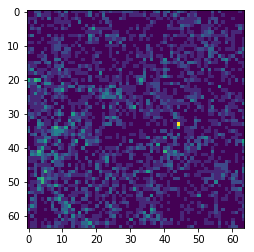

In [56]:
imshow(preds[1,:,:,:,0].sum(axis=-1))

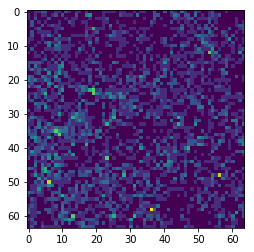

In [57]:
imshow(cube_target[3][1,:,:,:,0].sum(axis=-1))

In [18]:
tf.reset_default_graph()

# module = hub.Module('./models/galmodel/module2/1546437711/likelihood/')
module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')
pad = 2

xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 2], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']

preds = {}
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    for seed in seeds:
        xxm = np.pad(meshes[seed][0]['cic'], pad, 'wrap')
        yym = np.stack([meshes[seed][1]['pnncen'], meshes[seed][1]['pnnsat']], axis=-1)
#         xxm, yym = meshes[seed][0]['cic'], np.stack([meshes[seed][1]['pnncen'], meshes[seed][1]['pnnsat']], axis=-1)
        preds[seed] = sess.run(samples, feed_dict={xx:np.expand_dims(np.expand_dims(xxm,  -1), 0), yy:np.expand_dims(yym, 0)})
        meshes[seed][0]['predictcen'] = preds[seed][:, :, :, 0]
        meshes[seed][0]['predictsat'] = preds[seed][:, :, :, 1]
        #         likes = sess.run(loglik, feed_dict={xx:features, yy:targets})
        


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


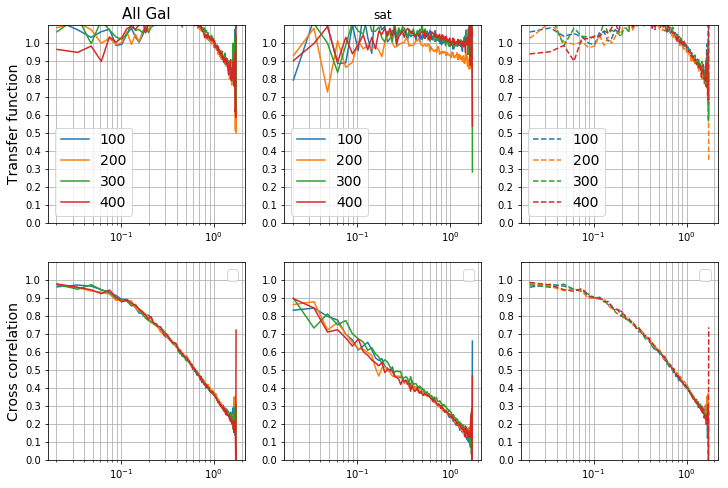

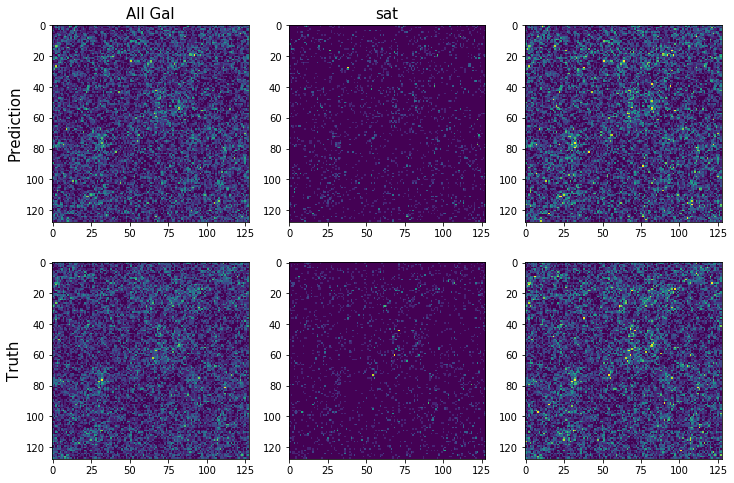

In [19]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in seeds:
    for i, key in enumerate(['cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)

    i=2
    predict, hpmeshd = meshes[seed][0]['predictcen']+meshes[seed][0]['predictsat'] ,\
        meshes[seed][1]['pnncen']+meshes[seed][1]['pnnsat']
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate([ 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
i=2
predict, hpmeshd = meshes[seed][0]['predictcen']+meshes[seed][0]['predictsat'] ,\
        meshes[seed][1]['pnncen']+meshes[seed][1]['pnnsat']
im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


# Test Eiffl

In [11]:
#############################
# meshes = {}

num_cubes= 1000
cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad


tf.reset_default_graph()
module = hub.Module('modules/1544168303/likelihood')
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 2], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']


tseeds = [100,  400]
meshes = {}

for seed in tseeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    
    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
    hmesh['mnnsat'] = tools.paintnn(hposd[galtype], bs, ncp, massd[galtype])
    hmesh['mnncen'] = tools.paintnn(hposd[~galtype], bs, ncp, massd[~galtype])

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube).astype('float32')
    outp = dtools.splitvoxels(targetmesh, cube_size=cube_size, shift=cube_size, ncube=ncube).astype('float32')
    
    with tf.Session() as sess:
        sess.run(tf.initializers.global_variables())
        recp = sess.run(samples, feed_dict={xx:inp, yy:outp})
    satmesh = recp[:,:,:,:,1]
    cenmesh = recp[:,:,:,:,0]
    
    mesh['predictsat'] = dtools.uncubify(satmesh[:,:,:,:], [nc,nc,nc])
    mesh['predictcen'] = dtools.uncubify(cenmesh[:,:,:,:], [nc,nc,nc])
    mesh['predict'] = mesh['predictcen'] + mesh['predictsat']
    meshes[seed] = [mesh, hmesh]

    
    
     
    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
All the mesh have been generated for seed = 100
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 400
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


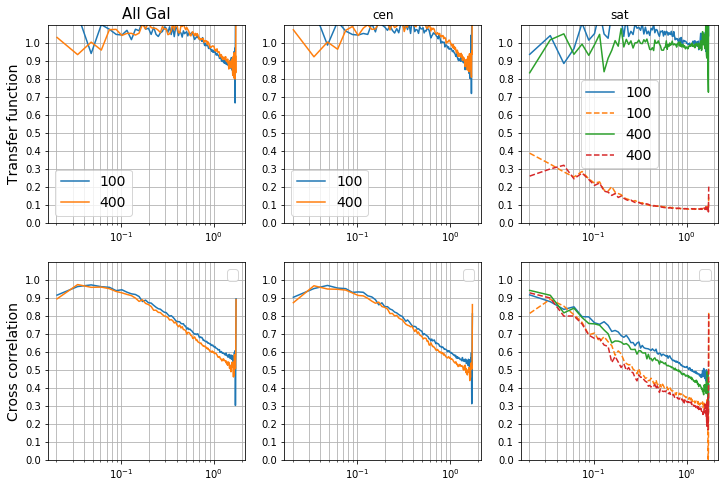

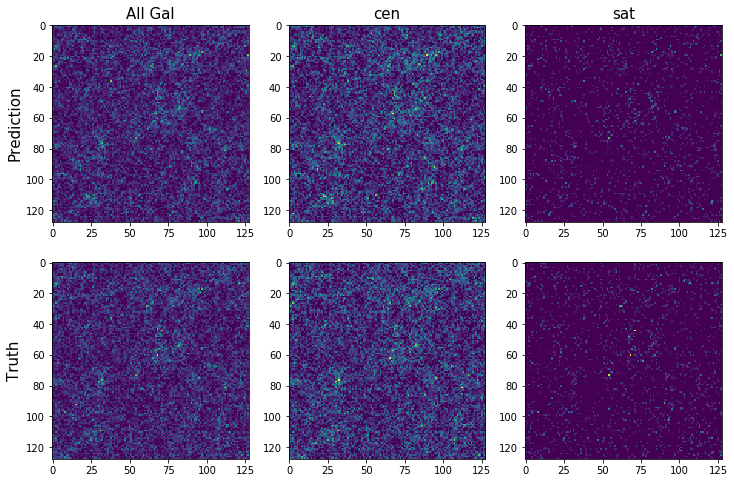

In [12]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['predict'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


# Test halos splitvoxel

In [28]:
#############################
# meshes = {}

num_cubes= 1000
cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad


tf.reset_default_graph()
module = hub.Module('/home/chmodi/Projects/galmodel/code/models/n10/pad2_32/module/1547516285/likelihood')
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, 1], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']


tseeds = [100,  400]
meshes = {}

for seed in tseeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['pnn']
    ntarget = len(targetmesh)

    print('All the mesh have been generated for seed = %d'%seed)

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube).astype('float32')
    outp = dtools.splitvoxels(targetmesh, cube_size=cube_size, shift=cube_size, ncube=ncube).astype('float32')
    
    with tf.Session() as sess:
        sess.run(tf.initializers.global_variables())
        recp = sess.run(samples, feed_dict={xx:inp, yy:outp})
    
    mesh['predict'] = dtools.uncubify(recp[:,:,:,:], [nc,nc,nc])
    meshes[seed] = [mesh, hmesh]

    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
All the mesh have been generated for seed = 100
All the mesh have been generated for seed = 100
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 400
All the mesh have been generated for seed = 400
(32, 32, 32) [128 128 128]


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.


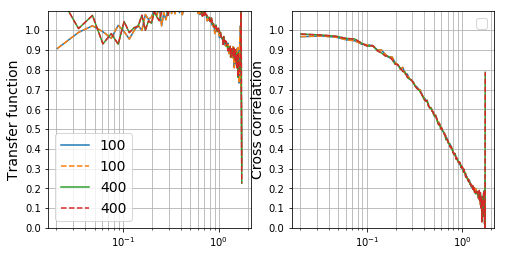

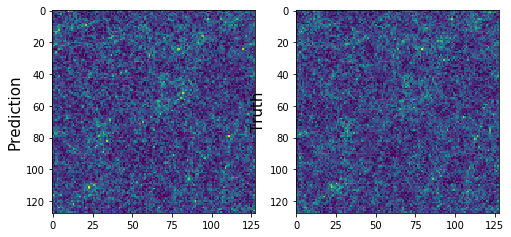

In [29]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
for seed in tseeds:
    key = ''
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0].set_ylabel('Transfer function', fontsize=14)
ax[1].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i, key in enumerate(['']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()
